# **Everything you need to know about TBATS**

### **Model Discription**

TBATS is a model which is used for modeling time series with several seasonalities.

TBATS is an acronym which denote the following features:

* T - trigonometric regressors to model multiple-seasonalitie
* B - Box-Cocks
* A - ARMA errors
* T - trend
* S - seasonality

### **Equation of the TBATS**

To begin with, let's start from writting down the equation for the TBATS in general form.

$
\begin{split}
&\begin{split}
\text{Model Part}&\\
y_t^{(\lambda)} &= l_{t-1} + \phi b_{t-1} + \sum_{i=1}^{T}s_{t-m_i}^{(i)} + d_{t-1} \\ 
l_t &= l_{t-1} + \phi b_{t-1} + \alpha d_t \\ 
b_t &= \phi b_{t-1} + \beta d_t \\
d_t &= \sum_{i=1}^{p}\varphi d_{t-i} + \sum_{i=1}^{q}\theta_ie_{t-i}+e_t \\
\end{split}
\quad \quad \quad \quad \quad \quad \quad \quad
\begin{split}
\text{Where}&\\
y_t^{(\lambda)}&\text{ - time series at moment t (Box-Cox)} \\ 
s_t^{(i)} &\text{ - } i^{th} \text{seasonal component} \\
l_t&\text{ - local level} \\
b_t&\text{ - trend with damping} \\
d_t&\text{ - ARMA(p,q) process for residuals} \\ 
e_t&\text{ - Gaussian white noise}
\end{split} \\
&
\begin{split}
\text{Seasonal Part}&\\
s_t^{(i)} &= \sum_{j=1}^{(k_i)}s_{j,t}^{(i)} \\ 
s_{j,t}^{(i)} &= s_{j,t-1}^{(i)}\cos(\omega_j^{(i)}) + s_{j,t-1}^{(i)}\sin(\omega_j^{(i)}) + \gamma_1^{(i)}d_t \\
s_{j,t}^{*(i)} &= -s_{j,t-1}^{(i)}\sin(\omega_j^{(i)})+s_{j,t-1}^{*(i)}\cos(\omega_j^{(i)}) + \gamma_2^{(i)}d_t \\
\omega_j^{(i)} &= 2\pi \frac{j}{m_i}
\end{split}
\quad \quad \quad
\begin{split}
\text{Model } & \text{parameters}\\
T &\text{ - number of seasonalities} \\ 
m_i&\text{ - length of i^{th} seasonal component} \\
k_i&\text{ - amount of harmonics for i^{th} seasonal period} \\
\lambda&\text{ - Box-Cox transformation} \\
\alpha,\beta&\text{ - smoothing}\\
\phi&\text{ - trend damping}\\ 
\varphi_i, \theta_i&\text{ - ARMA(p,q) coefficients}\\
\gamma_1^{(i)}, \gamma_2^{(i)}&\text{ - seasonal smoothing}\\
\end{split}
\end{split}
$

From the descriptions on the right, it is clear what is a puprose of each term in the equations, so we will move straight to implementations of this model.

### Importing libraries

Usaully for working with time series and time series models library sktime is used. It is not a default library and usually you have to install it. In order to do that, you have to run the following command in terminal `pip install sktime`. Or if you work in jupyter you can simply and `!` sign to run terminal commands from jupyter cells.

However, at the moment this tutorial is created TBATS model is poorly implented there. Thus, we advise to use library `tbats`. We can install it the same way we install sktime: `pip install TBATS`.

In [1]:
!pip install sktime
!pip install TBATS

Here we import libraries and functions that we will need for working with time series. Except `sktime` and `tbats` that we already mentioned, all other libraries are very common and we expect that you already familiar with them.

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import datetime as dt
from sktime.utils.plotting import plot_series
from sktime.forecasting.model_selection import temporal_train_test_split
from tbats import TBATS

# turning off warnings notifications
import warnings
warnings.filterwarnings('ignore')

# just setting parameters for the plot
plt.style.use('seaborn-white')
plt.rc('font', size=9)
plt.rc('figure', titlesize=18)
plt.rc('axes', labelsize=15)
plt.rc('axes', titlesize=18)

### Loading data

For this tutorial we are going to use `AEP_hourly` dataset from one of the Kaggle competitions https://www.kaggle.com/robikscube/hourly-energy-consumption. Let's load it and investigate it.

In [3]:
y = pd.read_csv("AEP_hourly.csv", index_col=0)['AEP_MW']
y

Datetime
2004-12-31 01:00:00    13478.0
2004-12-31 02:00:00    12865.0
2004-12-31 03:00:00    12577.0
2004-12-31 04:00:00    12517.0
2004-12-31 05:00:00    12670.0
                        ...   
2018-01-01 20:00:00    21089.0
2018-01-01 21:00:00    20999.0
2018-01-01 22:00:00    20820.0
2018-01-01 23:00:00    20415.0
2018-01-02 00:00:00    19993.0
Name: AEP_MW, Length: 121273, dtype: float64

In short, it is a time series that shows the hourly power consumption in Megawatts of the PJM transmition company in the Unated States.

For fitting time series model it is better to have indexes to be time periodic. This can be achieved using `PeriodicIndex()` function from Pandas.

In [4]:
# we set frequence to hours as it is hourly dataset
y.index = pd.PeriodIndex(y.index, freq='H')
y.sort_index(inplace=True)
y

Datetime
2004-10-01 01:00    12379.0
2004-10-01 02:00    11935.0
2004-10-01 03:00    11692.0
2004-10-01 04:00    11597.0
2004-10-01 05:00    11681.0
                     ...   
2018-08-02 20:00    17673.0
2018-08-02 21:00    17303.0
2018-08-02 22:00    17001.0
2018-08-02 23:00    15964.0
2018-08-03 00:00    14809.0
Freq: H, Name: AEP_MW, Length: 121273, dtype: float64

## Investigating the data

First, let's plot the whole time series.

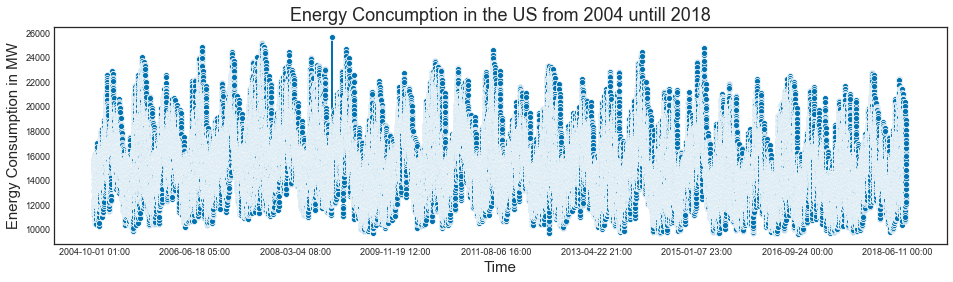

In [5]:
fig, ax = plot_series(y)
plt.title('Energy Concumption in the US from 2004 untill 2018')
plt.xlabel('Time')
plt.ylabel('Energy Consumption in MW')

plt.show()

As we can see the data is overcrowded, but anyway we can see some repeating patterns. As this is the data abount energy consumption, we may suppsoe first to see the yearly seasonality. People tend to spend more energy during the winter because days are shorter and we need to turn on lighting for longer time per day and also it is colder, so we should expect to 

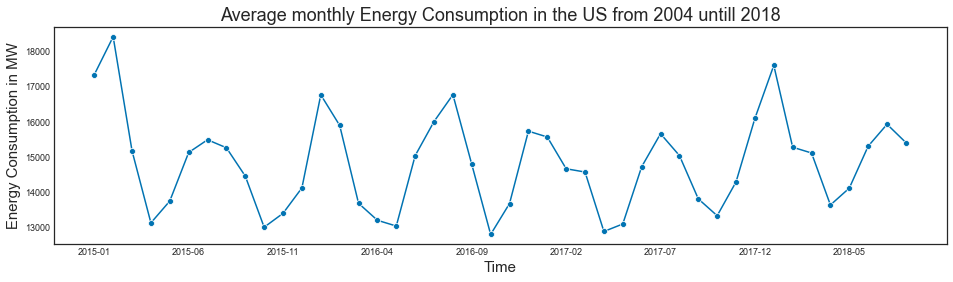

In [6]:
month_avg = y.resample('M').mean()
fig, ax = plot_series(month_avg[month_avg.index.year > 2014])
plt.title('Average monthly Energy Consumption in the US from 2004 untill 2018')
plt.xlabel('Time')
plt.ylabel('Energy Consumption in MW')
plt.show()

We can see that there is clearly a yearly seasonality. However, it is a bit different in comparison with what we expected.

The eneragy consumption is the highest in January (month 01) and July (month 07). Energy consumption may be higher during the summer as we usually spend energy on cooling our houses during the hot summer.

Also, we may expect weekly seasonality, as during the working days companies need supply offices with required energy.
Let's consider daily everage energy consuption for octobre 2017.

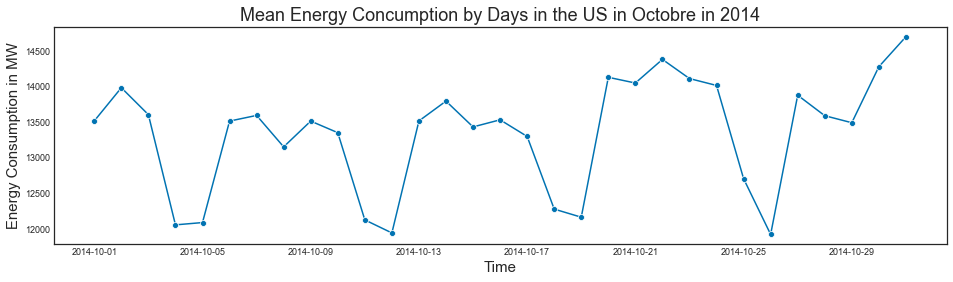

In [7]:
week_avg = y.resample('D').mean()
week_avg = week_avg[week_avg.index.year == 2014]
week_avg = week_avg[week_avg.index.month == 10]
fig, ax = plot_series(week_avg)
plt.title('Mean Energy Concumption by Days in the US in Octobre in 2014')
plt.xlabel('Time')
plt.ylabel('Energy Consumption in MW')
plt.show()

Here on the graph you can see a weekly seasonality. During the working days energy consumption is higher and during the weekends is lower as it was expected.

Finally, we also should expect daily seasonality in energy consumption for obvious reasons. Let's check by drawing hourly energy consumption for 4 days randomly chosen days.

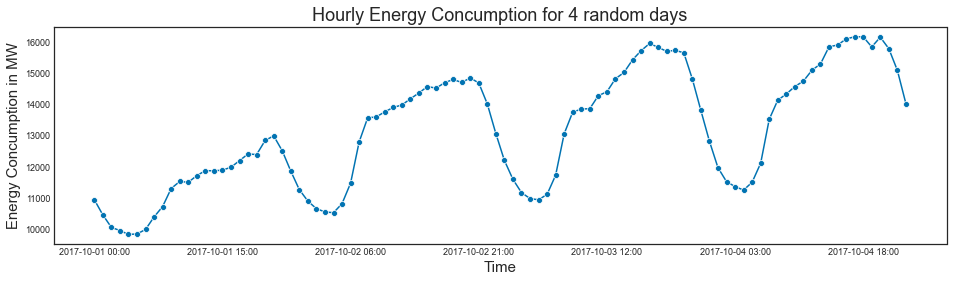

In [8]:
y_day = y[y.index.year == 2017]
y_day = y_day[y_day.index.month == 10]
y_day = y_day[y_day.index.day <= 4]
fig, ax = plot_series(y_day)
plt.title('Hourly Energy Concumption for 4 random days')
plt.xlabel('Time')
plt.ylabel('Energy Concumption in MW')
plt.show()

To sum up, this dataset has 3 different seasonalities: yearly, weekly, daily.

### Fitting the model

For model fitting we will use only 3 months of the year 2017 (semptebre, octore, november) of the given dataset otherwise it will take too long to fit the model as dataset is huge (It took 30+ minutes for auto-tuning on our computers. If you have very good computer, you may try to run on the whole dataset). Of course, like this we won't be able to model yearly seasonality, but there will be another two: weekly and daily. So, we will be able to show TBATS feature of modeling time series with multiple seasonalities.

In [9]:
y_2017 = y[y.index.year == 2017]
y_2017 = y_2017[y_2017.index.month >= 9]
y_2017 = y_2017[y_2017.index.month <=11]
y_2017

Datetime
2017-09-01 00:00    13214.0
2017-09-01 01:00    12372.0
2017-09-01 02:00    11819.0
2017-09-01 03:00    11506.0
2017-09-01 04:00    11437.0
                     ...   
2017-11-30 19:00    15506.0
2017-11-30 20:00    15496.0
2017-11-30 21:00    15311.0
2017-11-30 22:00    14978.0
2017-11-30 23:00    14402.0
Freq: H, Name: AEP_MW, Length: 2185, dtype: float64

We should split data on training and test sets. We can use special function from sktime library `temporal_train_test_split`.

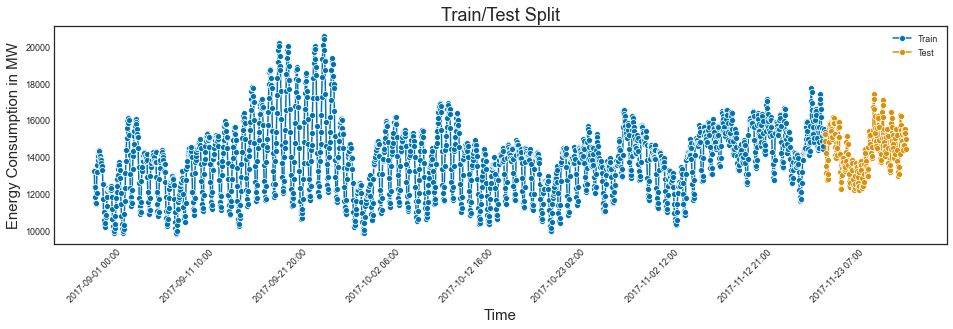

In [10]:
y_train, y_test = temporal_train_test_split(y_2017, test_size=0.1)

# plot data
fig, ax = plot_series(y_train, y_test, labels=['Train', 'Test'])
plt.title('Train/Test Split')
plt.xlabel('Time')
plt.ylabel('Energy Consumption in MW')
plt.setp(ax.xaxis.get_majorticklabels(), rotation=45)
plt.show()

To fit TBATS we will use `TBATS` class from module `tbats`.

`TBATS()` has several parameters which determine the model:

1. `use_box_cox` - If True, applies Box-Cox transformation. By default is None
2. `box_cox_bounds` - Minimal and maximal Box-Cox parameter values. By default is (0, 1)
3. `use_trend` - If True, include trend component. By default is None,
4. `use_damped_trend` - If True, include dumped trend component. By default is None.
5. `sp` - Array if integer or floats which determine seasonalities. By default is none. 
6. `use_arma_errors` - If True, include ARMA component. By default is none.

So, in order to fit the model, there are two options. Fisrt, pass all the paramters by hand (or using cross validation functions for example from sklearn) or just initialize TBATS model without passing values for the parameters. In the later case, it will choose best possible option by itself.

However, `TBATS` cannot determine the best possible value of `sp` parameter that is responsible for the seasonalities, so if you want your model to have seasonaliities, you should anyway pass values of this paramter by hand. And also it cannot determine the best bouds for the box cox tranformation.

For this reason we spent so many time studying the dataset in order to determine seasonalities.

Let's fit some model to see how it works. First, let's consider the case of determing the parameters by hand.

We do not to include trend componenents as according to graphs we can't see any trend. For sake of simplicicty, for first example we decided to get rid of ARMA errors and do not use the Cox-Box transform. But we defined daily and weekly seasonalities. For this data we set seasonal periods to be equal to 24 and 24*7 as data is hourly (24 hours = 1 day, 24*7 hours = 1 week).

In order to create the model we first imported class `TBATS` from library `tbats` and now just call its generator.

In [11]:
test_model = TBATS(use_box_cox=False, use_trend=False, use_damped_trend=False, use_arma_errors=False, seasonal_periods=[24, 24*7])

In order to fit the model, we use method `.fit()` and pass training data as a parameter for the method.

Do not worry, it can take some time to fit the model, especially if the dataset is huge.

In [12]:
test_model = test_model.fit(y_train)

We also can run the `.summary()` method in order to get information about the model I've got. This can be very useful when you use auto-fitting.

In [13]:
print(test_model.summary())

Use Box-Cox: False
Use trend: False
Use damped trend: False
Seasonal periods: [ 24. 168.]
Seasonal harmonics [11  2]
ARMA errors (p, q): (0, 0)
Smoothing (Alpha): 1.578975
Seasonal Parameters (Gamma): [-1.75705018e-04  1.07320774e-04  6.59317889e-05  8.96200149e-05]
AR coefficients []
MA coefficients []
Seed vector [ 1.32503866e+04 -8.47064611e+02  9.38852246e+01  4.49023982e+01
 -1.22070812e+02 -6.24043620e+01  2.10546208e+01  1.75536649e+01
 -1.13930433e+01  1.11943364e+00  4.44367016e+00 -2.41029772e+00
 -1.46676282e+03 -6.29110633e+02 -8.37322260e+01  4.50437249e+01
 -2.54987588e+01 -1.10329316e+01  2.86374223e+01 -7.44018866e+00
 -9.51037622e+00  1.50547115e+00  3.06847678e+00  9.49305671e+01
  2.92810144e+02 -8.56913340e+02  2.66539083e+02]

AIC 36193.984245


Let's see how to correctly interpret the obtained results.

1. We can see that Box-Cox, trend and dumped trend paramters are equal to False, because we decided not to include them in to our model.

2. AR and MA coefficients are empty arrays, as we also didn't use them for this model.

3. Seasonal periods are set to the values that we defined for them. As a result, we can see non-empty lists of seasonal harmonics and seasonal parameters for the model. As we can see that model do not experience any troubles with multiple seasonalities.

In order to better undertand, what is going on, we can write down formula for the given model. Luckely, `.summary()` method provides enough information for us.

As trend, dumped trend and ARMA are not used, we remove all of these veriables from the formula. So, the model part will be the following:

$
\begin{split}
&\text{Model Part}\\
y_t &= l_{t-1} + \sum_{i=1}^{T}s_{t-m_i}^{(i)}\\ 
l_t &= l_{t-1}
\end{split}
$

Next we have to write down the seasonal part.

$
\begin{split}
&\text{Seasonal Part}\\
s_t^{(i)} &= \sum_{j=1}^{(k_i)}s_{j,t}^{(i)} \\ 
s_{j,t}^{(i)} &= s_{j,t-1}^{(i)}\cos(\omega_j^{(i)}) + s_{j,t-1}^{(i)}\sin(\omega_j^{(i)})\gamma_1^{(i)}d_t \\
s_{j,t}^{*(i)} &= -s_{j,t-1}^{(i)}\sin(\omega_j^{(i)})+s_{j,t-1}^{*(i)}\cos(\omega_j^{(i)})+\gamma_2^{(i)}d_t \\
\omega_i &= 2\pi \frac{j}{m_i}
\end{split}
$

1. We have two seasonal components, so $i \in \{1,2\}$.
2. $k_i$ is number of harmonics for $i^{th}$ seasonal component, then $k_1 = 11, k_2 = 2$.
3. $m_i$ is a length if $i^{th}$ seasonal period, then $m_1 = 24, m_2 = 24*7 = 168$
4. $\gamma_1^{(i)}$ and $\gamma_2^{(i)}$ are parameters of seasonal smoothing, then $\gamma_1^{(1)} = -1.75705018e-04, \gamma_2^{(1)} = 1.07320774e-04, \gamma_1^{(2)} = 6.59317889e-05, \gamma_2^{(2)} = 8.96200149e-05$. However, as we do not have ARMA part in our model, then $d_t = 0$, so the terms with gammas disappear.


Finally, we will have the following model:

$
\begin{split}
&\text{Model Part}\\
y_t &= l_{t-1} + s_{t-24}^{(1)} + s_{t-168}^{(2)}\\ 
l_t &= l_{t-1}\\
&\text{Seasonal Part}\\
s_t^{(1)} &= \sum_{j=1}^{11}s_{j,t}^{(1)} \\ 
s_{j,t}^{(1)} &= s_{j,t-1}^{(1)}\cos(\omega_j^{(1)}) + s_{j,t-1}^{*(1)}\sin(\omega_j^{(1)}) \\
s_{j,t}^{*(1)} &= -s_{j,t-1}^{(1)}\sin(\omega_j^{(1)})+s_{j,t-1}^{*(1)}\cos(\omega_j^{(1)}) \\
\omega_j^{(1)} &= 2\pi \frac{j}{24}\\
s_t^{(2)} &= \sum_{j=1}^{2}s_{j,t}^{(2)} \\ 
s_{j,t}^{(2)} &= s_{j,t-1}^{(2)}\cos(\omega_j^{(2)}) + s_{j,t-1}^{*(2)}\sin(\omega_j^{(2)}) \\
s_{j,t}^{*(2)} &= -s_{j,t-1}^{(2)}\sin(\omega_j^{(2)})+s_{j,t-1}^{*(2)}\cos(\omega_j^{(2)}) \\
\omega_j^{(2)} &= 2\pi \frac{j}{168}
\end{split}
$

Notice that `.summary()` method also returns value of the AIC criterion. In this tutorial we are not going to talk in details about the AIC criterion, but you should know that the lower is the value of the AIC criterion, the better.

### Predicting with TBATS model

Now let's predict with our model and compare its results to the true values. In order to forecast, we can use the `.forecast()` method in which you should only specify the number of steps you want to predict. As our data provides hourly information, then for this dataset 1 step is 1 hour.

So, we run `.forecast()` method for the number of steps equal to the length of our test dataset.

In [14]:
y_pred = test_model.forecast(len(y_test))

The `.forecast()` method returns an array. We will turn it into a series data just to make it of the same type as our test data.

In [15]:
y_pred = pd.Series(index = y_test.index, data = y_pred)

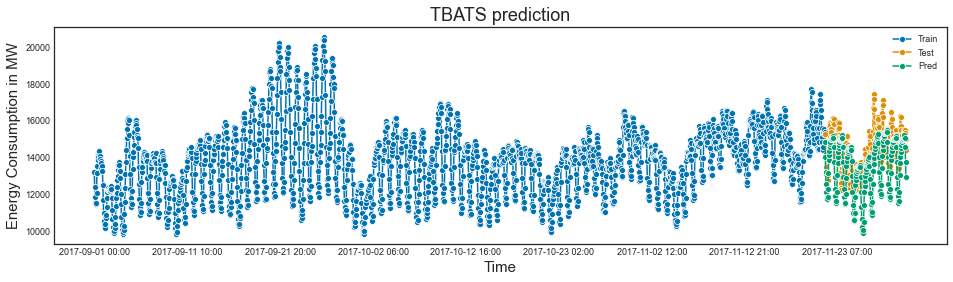

In [16]:
plot_series(y_train, y_test, y_pred, labels=['Train', 'Test', 'Pred']);
plt.title('TBATS prediction')
plt.xlabel('Time')
plt.ylabel('Energy Consumption in MW')
plt.setp(ax.xaxis.get_majorticklabels(), rotation=45)
plt.show()

We can see that even our very simple model performs very well, but still it a little bit underestimates the true data. It may happend because of our simplifications. So, let's use auto-fitting in order to select the better model fot the given dataset.

### Auto-fitting of TBATS

If you initialize TBATS model and specify only seasonal period, it will find the best possible combinations of other paramters by itself. However, it may take a very long time for model to find the best posible set of parameters. So, if you, for example, completely sure that there is no trend component, you can set it to be equal to `False`.

Again, for the auto-fitting we set seasonal periods to be equal to 24 and 24*7 for daily and weekly trends.

In [17]:
# ATTENTION fot those who will run this code.
# Dependin on the computer you use, auto-fitting even of 3 months of the given data may take very long time.
# For us it took about 5 minutes!

best_model = TBATS(seasonal_periods=[24, 24*7])
best_model = best_model.fit(y_train)
print(best_model.summary())

Use Box-Cox: True
Use trend: True
Use damped trend: True
Seasonal periods: [ 24. 168.]
Seasonal harmonics [11  2]
ARMA errors (p, q): (0, 0)
Box-Cox Lambda 0.000000
Smoothing (Alpha): 1.249501
Trend (Beta): 0.570316
Damping Parameter (Phi): 0.800000
Seasonal Parameters (Gamma): [-5.77208341e-07  8.82817274e-07 -3.98282977e-07 -1.91630850e-06]
AR coefficients []
MA coefficients []
Seed vector [ 9.53608403e+00  1.39239721e-03 -6.33281521e-02  9.41816189e-03
  4.88496029e-03 -8.04176238e-03 -4.76508622e-03  1.51697276e-03
  1.57662605e-03 -8.30132140e-04  1.98355985e-05  3.60006825e-04
 -2.46857760e-04 -1.09783552e-01 -4.98987546e-02 -6.76767270e-03
  3.64820390e-03 -1.78925790e-03 -1.28142922e-03  1.91693372e-03
 -3.93803570e-04 -8.28511030e-04 -3.39009894e-05  2.46514755e-04
 -8.13636941e-03  1.71861019e-02 -9.47266023e-02  2.65285042e-02]

AIC 35787.849761


This time the model decided to use Box-Cox tranform, trend and dumped trend components. For daily seasonality it used 11 harmonics and for weekly seasonality it used 2 harmonics. It also decided not to use ARMA components. We construct the equation of the model following the same procedure as for the previous case but include the trend components. So, we will have the following formula:

$
\begin{split}
&\text{Model Part}\\
y_t^{(\lambda)} &= l_{t-1} + 0.8 b_{t-1} + + s_{t-24}^{(1)} + s_{t-168}^{(2)}\\ 
l_t &= l_{t-1} + 0.8 b_{t-1} \\ 
b_t &= 0.8 b_{t-1} \\
&\text{Seasonal Part}\\
s_t^{(1)} &= \sum_{j=1}^{11}s_{j,t}^{(1)} \\ 
s_{j,t}^{(1)} &= s_{j,t-1}^{(1)}\cos(\omega_j^{(1)}) + s_{j,t-1}^{*(1)}\sin(\omega_j^{(1)}) \\
s_{j,t}^{*(1)} &= -s_{j,t-1}^{(1)}\sin(\omega_j^{(1)})+s_{j,t-1}^{*(1)}\cos(\omega_j^{(1)}) \\
\omega_j^{(1)} &= 2\pi \frac{j}{24}\\
s_t^{(2)} &= \sum_{j=1}^{2}s_{j,t}^{(2)} \\ 
s_{j,t}^{(2)} &= s_{j,t-1}^{(2)}\cos(\omega_j^{(2)}) + s_{j,t-1}^{*(2)}\sin(\omega_j^{(2)}) \\
s_{j,t}^{*(2)} &= -s_{j,t-1}^{(2)}\sin(\omega_j^{(2)})+s_{j,t-1}^{*(2)}\cos(\omega_j^{(2)}) \\
\omega_j^{(2)} &= 2\pi \frac{j}{168}
\end{split}
$

In [18]:
y_pred_best = best_model.forecast(len(y_test))
y_pred_best = pd.Series(index = y_test.index, data = y_pred_best)

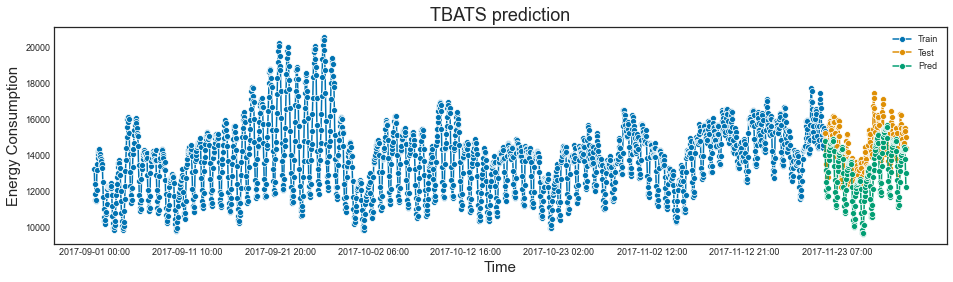

In [19]:
plot_series(y_train, y_test, y_pred_best, labels=['Train', 'Test', 'Pred']);
plt.title('TBATS prediction')
plt.xlabel('Time')
plt.ylabel('Energy Consumption')
plt.setp(ax.xaxis.get_majorticklabels(), rotation=45)
plt.show()

Looking at predicitons, we can see that the model still underestimates the true data. However, the AIC criterion is smaller this time and the predictions are little bit better in comparison with the previous model.

### Fitting TBATS model to the data with non-integer seasonality.

Another features of the TBATS model is that it can succefully model the non-integer seasonalities. In order to test this feature, let's consider another dataset that has non-integer seasonality.

For this part we are going to use Minimum Daily Temperatures in Australia, Melbourne. Dataset that can be dowloaded using this link https://raw.githubusercontent.com/jbrownlee/Datasets/master/daily-min-temperatures.csv. Let's load and investigate it.

In [20]:
y = pd.read_csv("https://raw.githubusercontent.com/jbrownlee/Datasets/master/daily-min-temperatures.csv", index_col=0)['Temp']
y.index = pd.PeriodIndex(y.index, freq='D')
y

Date
1981-01-01    20.7
1981-01-02    17.9
1981-01-03    18.8
1981-01-04    14.6
1981-01-05    15.8
              ... 
1990-12-27    14.0
1990-12-28    13.6
1990-12-29    13.5
1990-12-30    15.7
1990-12-31    13.0
Freq: D, Name: Temp, Length: 3650, dtype: float64

This dataset is much smaller, so we will use the whole dataset for future model fitting and prediction.

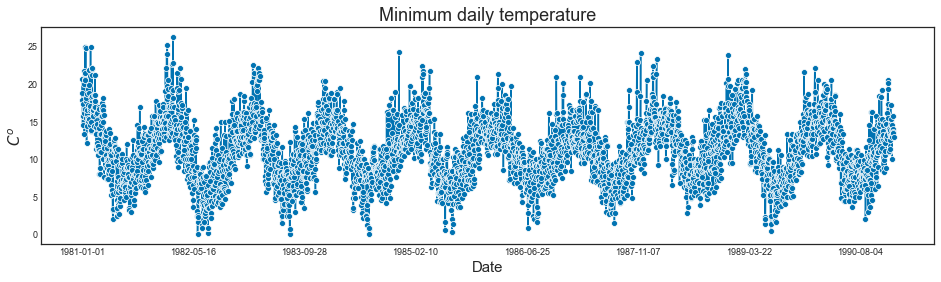

In [21]:
fig, ax = plot_series(y)
plt.title('Minimum daily temperature')
plt.xlabel(r'Date')
plt.ylabel(r'$C^o$')

plt.show()

As we can see the plot is a bit overcrowded. However, it is alredy clear that there is some seasonal pattern in it and no trend.

As it is dataset of minimum daily temperature, we should expect to see the yearly seasonality. As in the winterit is colder then in summer.

In order to see it more clearly, let's plot average monthly minimum temperature for the last 3 years.

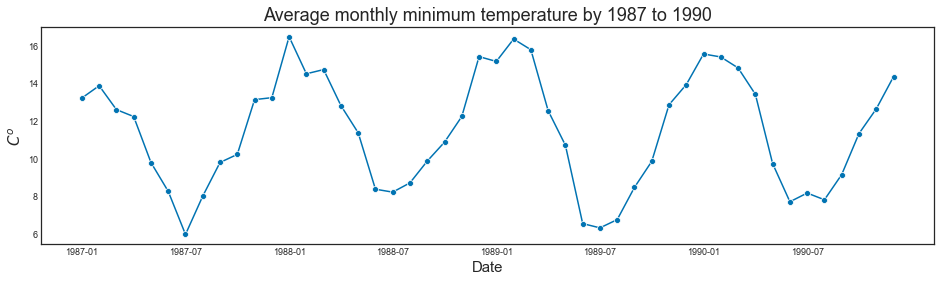

In [22]:
monthly_avg = y.resample('M')
monthly_avg = monthly_avg.mean()
monthly_avg = monthly_avg[monthly_avg.index.year  > 1986]
fig, ax = plot_series(monthly_avg)
plt.title('Average monthly minimum temperature by 1987 to 1990')
plt.xlabel(r'Date')
plt.ylabel(r'$C^o$')

plt.show()

Clearly, we can sea a yearly seasonal pattern. What may seem strange for some poeple that the lowest temperatures are at July (month 7) whereas the highest are in Junuary (month 1), but this dataset is from Australia, Melbourne.

Let's use auto-fitting to fit the TBATS model.
As we have niticed the yearly trend, we will use set seasonal periods equal to 365.25 in order to take into account the leap year.

In [23]:
y_train, y_test = temporal_train_test_split(y, test_size=0.1)
temp_model = TBATS(seasonal_periods=[365.25])
temp_model = temp_model.fit(y_train)
print(temp_model.summary())

Use Box-Cox: False
Use trend: False
Use damped trend: False
Seasonal periods: [365.25]
Seasonal harmonics [2]
ARMA errors (p, q): (2, 1)
Smoothing (Alpha): 0.015436
Seasonal Parameters (Gamma): [-1.53653269e-05 -3.29597439e-05]
AR coefficients [-3.29597439e-05  1.71511077e-01]
MA coefficients [0.52561164]
Seed vector [14.1649212   3.86654728 -0.42345413  1.56537686  0.33072762  0.
  0.          0.        ]

AIC 32308.316570


The equation for this model is the following (you can costruct it like for the previous cases, just substitute values of parameters into the equations):

$
\begin{split}
&\text{Model Part}\\
y_t^{(\lambda)} &= l_{t-1} + s_{t - 365.25}^{(1)} + d_{t-1} \\ 
l_t &= l_{t-1} + 0.015436 d_t \\ 
d_t &= -0.00000329597439d_{t-1} + 0.171511077d_{t-2} + 0.52561164 e_{t-i}+e_t \\
&\text{Seasonal Part}\\
s_t^{(1)} &= \sum_{j=1}^{2}s_{j,t}^{(1)} \\ 
s_{j,t}^{(1)} &= s_{j,t-1}^{(1)}\cos(\omega_j^{(1)}) + s_{j,t-1}^{*(1)}\sin(\omega_j^{(1)}) -0.00000153653269d_t \\
s_{j,t}^{*(1)} &= -s_{j,t-1}^{(1)}\sin(\omega_j^{(1)})+s_{j,t-1}^{*(1)}\cos(\omega_j^{(1)}) -0.00000329597439d_t \\
\omega_j^{(1)} &= 2\pi \frac{j}{365.25}\\
\end{split}
$

where $\omega_{1}^{(1)} = \frac{2\pi}{365.25}, \omega_{2}^{(1)} = \frac{4\pi}{365.25}$ (in this case we can write down values of omegas as there are only two of them).

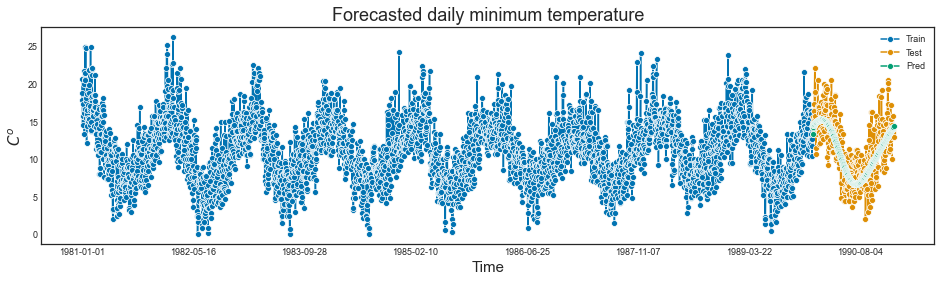

In [24]:
y_pred_temp = temp_model.forecast(len(y_test))
y_pred_temp = pd.Series(index = y_test.index, data = y_pred_temp)
plot_series(y_train, y_test, y_pred_temp, labels=['Train', 'Test', 'Pred']);
plt.title('Forecasted daily minimum temperature')
plt.xlabel('Time')
plt.ylabel(r'$C^o$')
plt.setp(ax.xaxis.get_majorticklabels(), rotation=45)
plt.show()

We can see that the model predicts observation very accurate. Yes, it didn't predicted all the fluctuations but it managed to forecast the general trend of how the minimum temperature changes over time. As we set only yearly seasonality, it is obvious that it didn't manage to mimic all the small fluctuations.

As we can see sometimes the feature of TBATS model to use non-integer seasonality can be really helpfull.

### Model Comparison using Sliding Window Algorithm and Smape Loss

AIC criterion is use only to choose the best model inside of one class. However if we want to compare models of different classes we should the sliding window.

We are going to compare **TBATS** with **ARIMA** and **ETS** models on the Minimum Daily Temperatures dataset. For comparison we will use the Sliding Window approach (further sw) which is very well described by this picture:

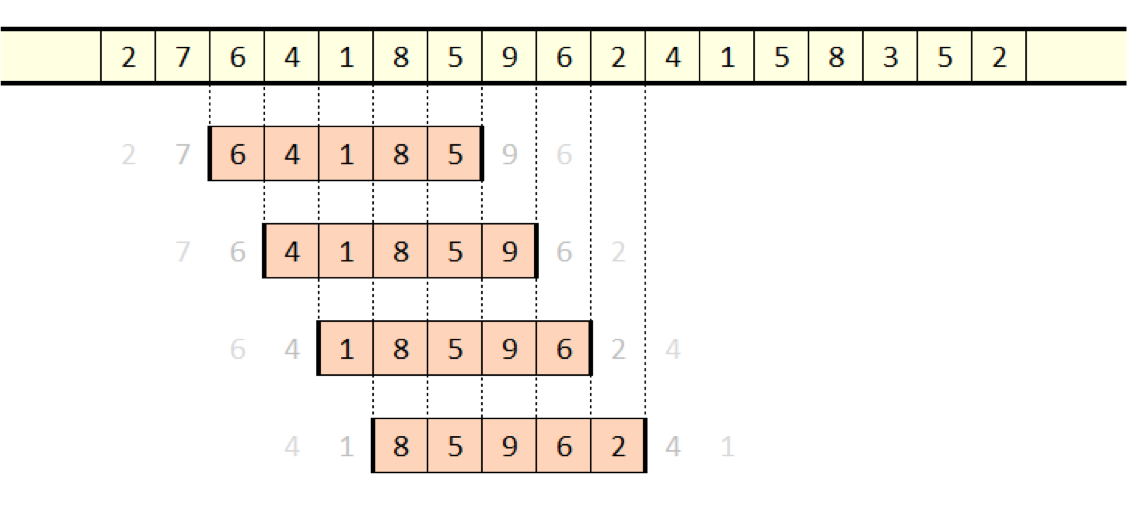

In our case each window will reperesent a sequence of train and test sets. 

In short, the process is very simple.

1. For each sliding window we split data on train and test.

2. We fit each model to the training data of current window.

3. We forecast with each model for the number of steps equal to the size of the test data.

4. We canlculate the smape loss (described below) for each model.

5. We save which model performed better on each of the windows.

6. We choose the model which performed better more times then the other.

SW algorithm is presented in `sktime` library (https://www.sktime.org/en/latest/api_reference/modules/auto_generated/sktime.forecasting.model_selection.SlidingWindowSplitter.html), however at the time of creation of this tutorial it is not impolemented properly for TBATS. For this reason, **we are going to write our own sw function**.

We are going to count the **Smape Loss** of the test data for each window. 
$$smape(y, \hat y) = \frac{1}{H} \sum_{i=T+1}^{T+H} \frac{|y_i - \hat y_i|}{(|y_i| + |\hat y_i|)/2}$$
Model with the lowest loss at a window wins. The best model will be the one with the most wins.

Here is out implementation of SlidingWindow function.

In [25]:
def SlidingWindow(y, window_len, step=1, test_share=0.3):
    """
    Input:
        1. time-series
        2. length of the window
        3. step by which the window slides each iteration
        4. share of test data in each window
    Output:
        Array of windows. Each window contains two seperate 
        arrays - train and test data.
    """

    l = len(y)

    if window_len > l or test_share>1:
        raise IndexError

    res = []
    test_share_val = int(window_len*test_share)
    for i in range(window_len, l, step):
        train = y[i-window_len:i-test_share_val]
        test = y[i-test_share_val:i]
        res.append([train, test])

    return res


windows = SlidingWindow(y=y, window_len=365*4, step=365, test_share=0.25)

### Testing

Now let's compate performace of TBATS, ETS and ARIMA models on the Minimum Daily Temperatures dataset. As this tutorial is not about ETS and ARIMA, we are not going to describe these models or provide instruction how to fit them. However, the process is very similar. We will use `AutoETS` and `AutoARIMA` from `sktime` library for auto-fitting of ETS and ARIMA models.

Also, we will use `smape_loss` function from `sktime` to calculate the `smape_loss`.

In [26]:
from sktime.forecasting.ets import AutoETS
from sktime.forecasting.arima import ARIMA, AutoARIMA
from sktime.forecasting.base import ForecastingHorizon 
from sktime.performance_metrics.forecasting import smape_loss

scores = np.zeros(3)
for i, window in enumerate(windows):
    print(f'Window {i+1}', end='\t')

    train, test = window
    test_index = pd.PeriodIndex(test.index, freq='D')
    test.sort_index(inplace=True)

    # 1 TBATS
    tbats_model = TBATS(seasonal_periods=[365.25]).fit(train)
    tbats_pred = tbats_model.forecast(len(test))
    tbats_pred = pd.Series(index = test_index, data = tbats_pred)
    print(f'TBATS done', end='\t')

    # 2 ETS
    horizon = ForecastingHorizon(test.index, is_relative=False)
    ets_auto_model = AutoETS(error='add', trend='add', seasonal='add', sp=365).fit(train)
    ets_pred = ets_auto_model.predict(horizon)
    ets_pred = pd.Series(index = test_index, data = ets_pred)
    print(f'ETS done', end='\t')

    # 3 ARIMA
    arima_model = AutoARIMA().fit(train)
    arima_pred = arima_model.predict(horizon)
    arima_pred = pd.Series(index = test_index, data = arima_pred)
    print(f'ARIMA done', end='\t')

    # smape loss
    tbats_loss = smape_loss(test, tbats_pred)
    ets_loss = smape_loss(test, ets_pred)
    arima_loss = smape_loss(test, arima_pred)

    scores[np.argmin([tbats_loss, ets_loss, arima_loss])] += 1
    print(f'Score: {scores}')

Window 1	TBATS done	ETS done	ARIMA done	Score: [1. 0. 0.]
Window 2	TBATS done	ETS done	ARIMA done	Score: [2. 0. 0.]
Window 3	TBATS done	ETS done	ARIMA done	Score: [3. 0. 0.]
Window 4	TBATS done	ETS done	ARIMA done	Score: [4. 0. 0.]
Window 5	TBATS done	ETS done	ARIMA done	Score: [5. 0. 0.]
Window 6	TBATS done	ETS done	ARIMA done	Score: [6. 0. 0.]


As we can see that TBATS has the most points. It performed better on each window. So, we will use this model for making our final predictions out of these three.